In [23]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Synchronous CUDA errors
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install opencv-python-headless
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
base_path = '/kaggle/input/voronoi-artificial-grains-gen/GRAIN DATA SET/'
ag_path = os.path.join(base_path, 'AG')
ag_mask_path = os.path.join(base_path, 'AGMask')
rg_path = os.path.join(base_path, 'RG')
rg_mask_path = os.path.join(base_path, 'RGMask')

print(f"AG files: {len(os.listdir(ag_path))}")
print(f"AGMask files: {len(os.listdir(ag_mask_path))}")
print(f"RG files: {len(os.listdir(rg_path))}")
print(f"RGMask files: {len(os.listdir(rg_mask_path))}")

Using device: cuda
AG files: 800
AGMask files: 800
RG files: 480
RGMask files: 480


In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNetSegmentation(nn.Module):
    def __init__(self):
        super(ResNetSegmentation, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.final_upconv = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.crop = lambda x: x[:, :, :304, :400]  # Crop to exact size
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        e1 = self.layer1(x)
        e2 = self.layer2(e1)
        e3 = self.layer3(e2)
        e4 = self.layer4(e3)
        d4 = self.upconv4(e4)
        d3 = self.upconv3(d4)
        d2 = self.upconv2(d3)
        d1 = self.upconv1(d2)
        out = self.final_upconv(d1)
        out = self.crop(out)
        return out

resnet_model = ResNetSegmentation().to(device)

In [28]:
## define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [29]:
## Train the model

num_epochs = 25
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        logits = resnet_model(images)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}")
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

torch.save(resnet_model.state_dict(), 'resnet_grain_segmentation.pth')

Epoch 1, Batch 0, Loss: 0.6801
Epoch 1, Batch 10, Loss: 0.3913
Epoch 1, Batch 20, Loss: 0.4425
Epoch 1, Batch 30, Loss: 0.3791
Epoch [1/25], Average Loss: 0.4539
Epoch 2, Batch 0, Loss: 0.4491
Epoch 2, Batch 10, Loss: 0.3694
Epoch 2, Batch 20, Loss: 0.3989
Epoch 2, Batch 30, Loss: 0.3805
Epoch [2/25], Average Loss: 0.3967
Epoch 3, Batch 0, Loss: 0.4111
Epoch 3, Batch 10, Loss: 0.3554
Epoch 3, Batch 20, Loss: 0.3591
Epoch 3, Batch 30, Loss: 0.3296
Epoch [3/25], Average Loss: 0.3639
Epoch 4, Batch 0, Loss: 0.3343
Epoch 4, Batch 10, Loss: 0.3284
Epoch 4, Batch 20, Loss: 0.3348
Epoch 4, Batch 30, Loss: 0.3101
Epoch [4/25], Average Loss: 0.3298
Epoch 5, Batch 0, Loss: 0.3278
Epoch 5, Batch 10, Loss: 0.3042
Epoch 5, Batch 20, Loss: 0.2926
Epoch 5, Batch 30, Loss: 0.2911
Epoch [5/25], Average Loss: 0.3085
Epoch 6, Batch 0, Loss: 0.3064
Epoch 6, Batch 10, Loss: 0.2807
Epoch 6, Batch 20, Loss: 0.2846
Epoch 6, Batch 30, Loss: 0.2767
Epoch [6/25], Average Loss: 0.2830
Epoch 7, Batch 0, Loss: 0.29

In [30]:
## evaluate 
def dice_score(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def line_intercept_grain_size(mask, pixel_size=1.0):
    mask = (mask > 0.5).astype(np.uint8) * 255
    height, width = mask.shape
    line = mask[height // 2, :]
    edges = cv2.Canny(line.reshape(1, -1), 100, 200)
    num_intercepts = np.sum(edges > 0) // 2
    grain_size = (width * pixel_size) / num_intercepts if num_intercepts > 0 else width * pixel_size
    return grain_size

resnet_model.eval()
dice_scores_resnet = []
grain_sizes_pred_resnet = []
grain_sizes_true_resnet = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        logits = resnet_model(images)
        dice = dice_score(logits, masks)
        dice_scores_resnet.append(dice.item())
        pred_probs = torch.sigmoid(logits).cpu().numpy()
        pred_masks = (pred_probs > 0.5).astype(np.float32)
        true_masks = masks.cpu().numpy()
        for i in range(pred_masks.shape[0]):
            pred_mask = pred_masks[i, 0]
            true_mask = true_masks[i, 0]
            pred_size = line_intercept_grain_size(pred_mask)
            true_size = line_intercept_grain_size(true_mask)
            grain_sizes_pred_resnet.append(pred_size)
            grain_sizes_true_resnet.append(true_size)

avg_dice_resnet = np.mean(dice_scores_resnet)
avg_grain_size_pred_resnet = np.mean(grain_sizes_pred_resnet)
avg_grain_size_true_resnet = np.mean(grain_sizes_true_resnet)
print(f"ResNet - Average Dice Score: {avg_dice_resnet:.4f}")
print(f"ResNet - Average Predicted Grain Size (pixels): {avg_grain_size_pred_resnet:.2f}")
print(f"ResNet - Average True Grain Size (pixels): {avg_grain_size_true_resnet:.2f}")
print(f"ResNet - Grain Size Difference (Pred - True): {avg_grain_size_pred_resnet - avg_grain_size_true_resnet:.2f}")

ResNet - Average Dice Score: 0.9343
ResNet - Average Predicted Grain Size (pixels): 95.70
ResNet - Average True Grain Size (pixels): 81.67
ResNet - Grain Size Difference (Pred - True): 14.03


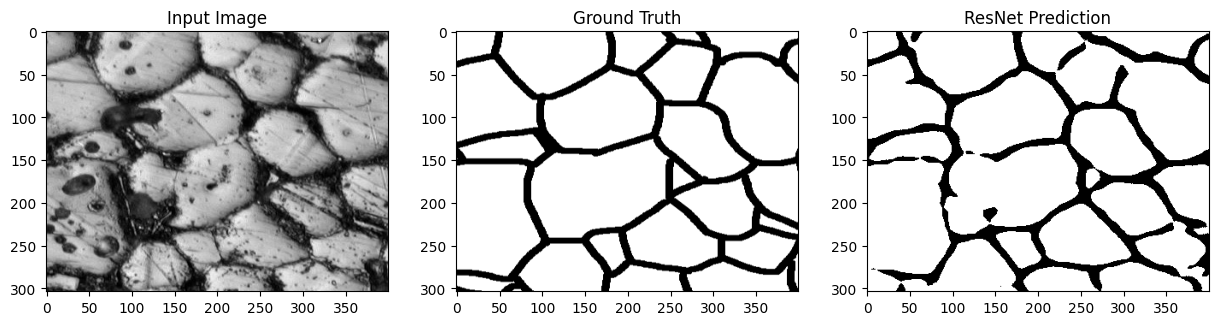

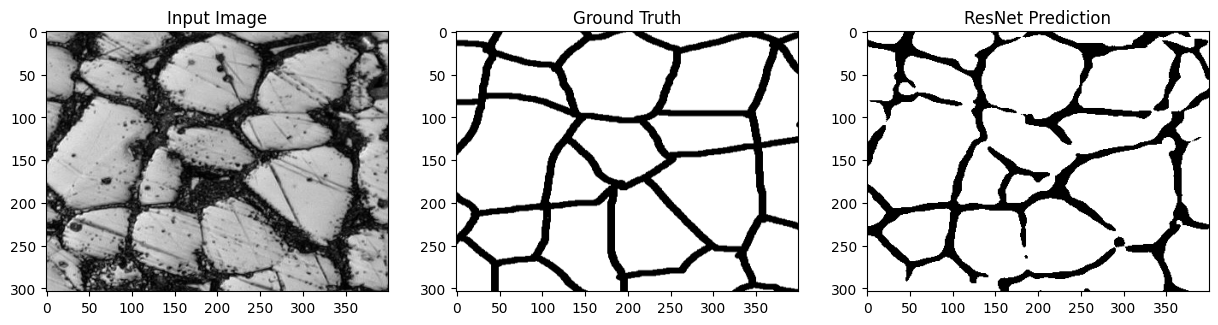

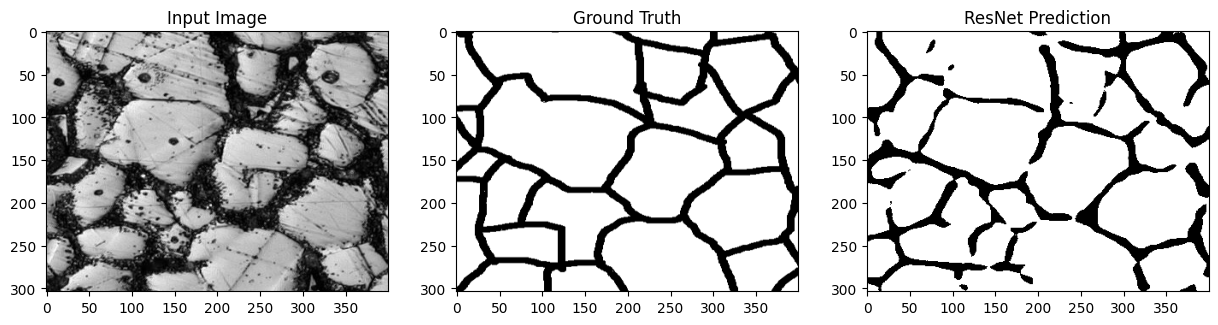

In [31]:
## visualize result
def visualize_prediction(image, mask, pred):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[0].set_title('Input Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[2].imshow(pred.squeeze(), cmap='gray')
    ax[2].set_title('ResNet Prediction')
    plt.show()

resnet_model.eval()
with torch.no_grad():
    for i in range(3):
        image, mask = test_dataset[i]
        image_tensor = image.unsqueeze(0).to(device)
        pred = resnet_model(image_tensor).cpu()
        visualize_prediction(image.numpy(), mask.numpy(), pred)